# Analysis of Integrated multi-omics single cell atlas of the human retina
- QC
- EDA
- Clustering
- Clustering Analysis

In [2]:
import sys
import scanpy as sc
import anndata as ad
import numpy as np

In [3]:
sys.version

'3.10.5 (main, Jul 19 2022, 08:28:45) [GCC 6.2.0]'

In [4]:
adata = sc.read_h5ad("d0183df5-815d-48c2-bcfe-fbf9b716505c.h5ad")

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 330930 × 32034
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'subclass_label', 'majorclass', 'author_cell_type', 'age', 'gender', 'reference', 'accession', 'sample_note', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_scVI', 'X_umap'


## QC

In [6]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var['feature_name'].str.startswith("mt-")

In [7]:
adata.var[adata.var["mt"]]

,gene_symbols,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,mt
ENSMUSG00000064357,mt-Atp6,False,mt-Atp6,NCBITaxon:10090,gene,681,True
ENSMUSG00000064356,mt-Atp8,False,mt-Atp8,NCBITaxon:10090,gene,204,True
ENSMUSG00000064351,mt-Co1,False,mt-Co1,NCBITaxon:10090,gene,1545,True
ENSMUSG00000064354,mt-Co2,False,mt-Co2,NCBITaxon:10090,gene,684,True
ENSMUSG00000064358,mt-Co3,False,mt-Co3,NCBITaxon:10090,gene,784,True
ENSMUSG00000064370,mt-Cytb,False,mt-Cytb,NCBITaxon:10090,gene,1144,True
ENSMUSG00000064341,mt-Nd1,False,mt-Nd1,NCBITaxon:10090,gene,957,True
ENSMUSG00000064345,mt-Nd2,False,mt-Nd2,NCBITaxon:10090,gene,1038,True
ENSMUSG00000064360,mt-Nd3,False,mt-Nd3,NCBITaxon:10090,gene,348,True
ENSMUSG00000064363,mt-Nd4,False,mt-Nd4,NCBITaxon:10090,gene,1378,True


In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

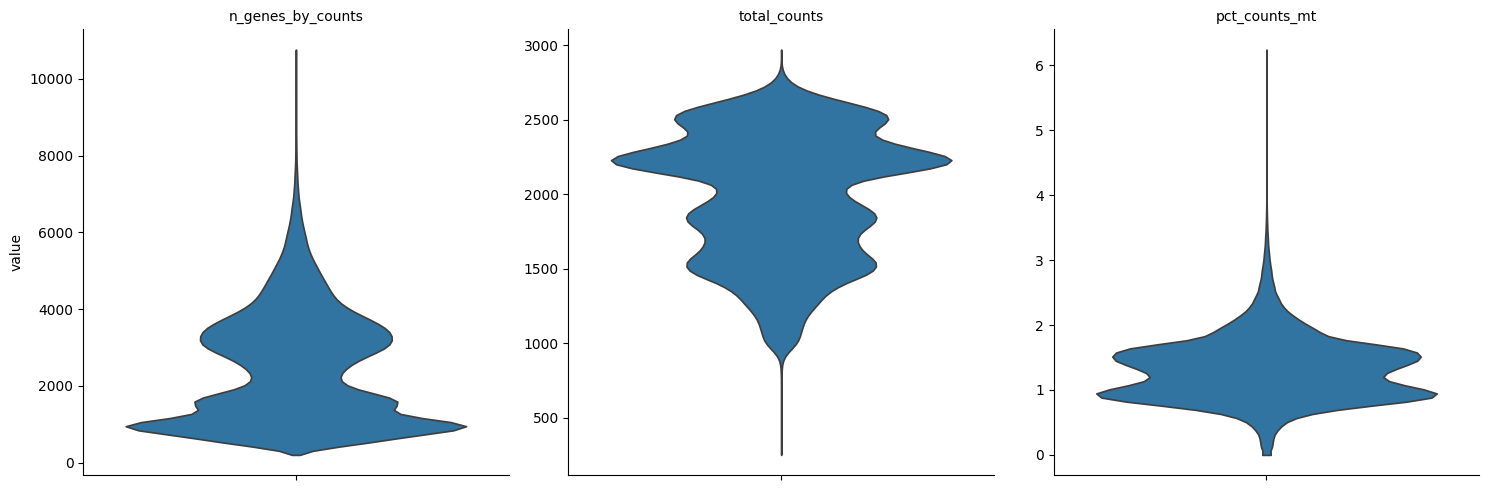

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot = False,
    multi_panel=True,
)

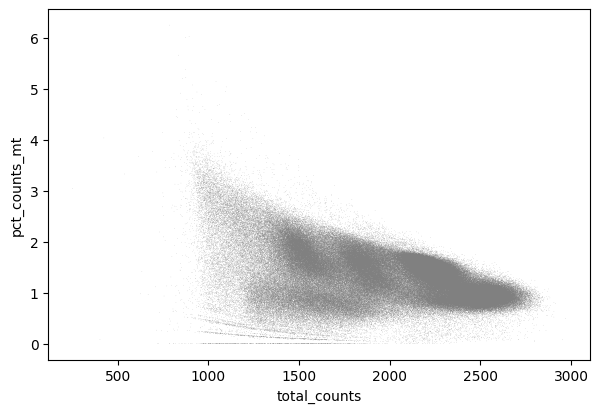

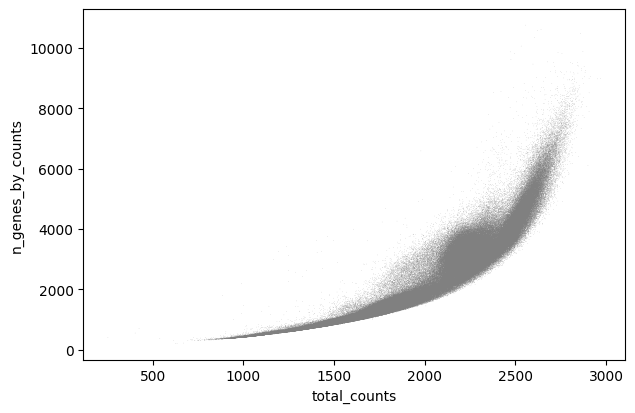

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Mitochondrial Sanity Check

In [11]:
# Get the mitochondrial genes
mitochondrial_genes = adata.var[adata.var['mt']]

# Get the names of mitochondrial genes
mitochondrial_genes_names = mitochondrial_genes['feature_name']

def print_gene_expression(cell_of_interest):
    # Get the gene expression values for mitochondrial genes for the specified cell
    gene_expression = adata[cell_of_interest, adata.var['mt']].X
    
    # Convert the sparse matrix to a dense array if necessary
    if hasattr(gene_expression, "toarray"):
        gene_expression = gene_expression.toarray()
    
    # Get the percent.mt value for the cell
    percent_mt = adata.obs.loc[cell_of_interest, 'percent.mt']
    
    # Display the gene expression values
    print(f"\nGene expression values for mitochondrial genes in {cell_of_interest} (percent.mt: {percent_mt:.2f}%):")
    for gene, expr in zip(mitochondrial_genes_names, gene_expression.flatten()):  # .flatten() to ensure it's a 1D array
        print(f"{gene}: {expr}")

# Specify the first cell by its index position
cell_mt_max = adata.obs['percent.mt'].idxmax()

# Find the cell with the highest percent.mt
cell_mt_min = adata.obs['percent.mt'].idxmin()

# Get the mitochondrial genes
mitochondrial_genes = adata.var[adata.var['mt']]

# Get the names of mitochondrial genes
mitochondrial_genes_names = mitochondrial_genes['feature_name']

# Print gene expression for the first cell
print_gene_expression(cell_mt_max)

# Print gene expression for the cell with the highest percent.mt
print_gene_expression(cell_mt_min)



Gene expression values for mitochondrial genes in 10x3_Ms_WT_P14_GTGTGGCGTCAACGCC-1 (percent.mt: 10.00%):
mt-Atp6: 4.5594353675842285
mt-Atp8: 1.276137351989746
mt-Co1: 4.33620548248291
mt-Co2: 4.414199352264404
mt-Co3: 4.6017842292785645
mt-Cytb: 4.039323806762695
mt-Nd1: 2.7384846210479736
mt-Nd2: 2.3319485187530518
mt-Nd3: 1.8189771175384521
mt-Nd4: 2.833989381790161
mt-Nd4l: 1.6355808973312378
mt-Nd5: 1.529503345489502
mt-Nd6: 0.4164412021636963

Gene expression values for mitochondrial genes in 10x3_Ms_WT_P14_AAGAACAGTATTAAGG-1 (percent.mt: 0.00%):
mt-Atp6: 0.0
mt-Atp8: 0.0
mt-Co1: 0.0
mt-Co2: 0.0
mt-Co3: 0.0
mt-Cytb: 0.0
mt-Nd1: 0.0
mt-Nd2: 0.0
mt-Nd3: 0.0
mt-Nd4: 0.0
mt-Nd4l: 0.0
mt-Nd5: 0.0
mt-Nd6: 0.0


### Filtering Cells

In [13]:
# Initial number of cells
initial_cells = adata.shape[0]

# Apply filters
adata = adata[adata.obs['n_genes_by_counts'] < 2500, :]
adata = adata[adata.obs['total_counts'] < 1e5, :]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]

# Final number of cells
final_cells = adata.shape[0]
total_removed = initial_cells - final_cells

print(f"Initial number of cells: {initial_cells}")
print(f"Final number of cells: {final_cells}")
print(f"Total cells removed: {total_removed}")

Initial number of cells: 330930
Final number of cells: 175273
Total cells removed: 155657


In [12]:
# Initial number of cells
initial_genes = adata.shape[1]

# Apply filters
sc.pp.filter_genes(adata, min_cells=3)

# Final number of cells
final_genes = adata.shape[1]
total_removed = initial_genes - final_genes

print(f"Initial number of cells: {initial_genes}")
print(f"Final number of cells: {final_genes}")
print(f"Total cells removed: {total_removed}")

Initial number of cells: 32034
Final number of cells: 27974
Total cells removed: 4060


In [ ]:
# Doublet test
adata_sub = sc.pp.subsample(adata, fraction = .01, copy = True)
print(adata_sub.shape)

sc.pp.scrublet(adata_sub)
print(adata_sub.obs["predicted_doublet"].sum())

(1752, 27974)
6


Looks like there's probably around 600 doublets

6
